<a href="https://colab.research.google.com/github/evinracher/3010090-ontological-engineering/blob/main/practice/agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller: LangGraph para Chatbots Inteligentes (Gemini)
**Objetivo:** practicar desde lo básico hasta memoria y checkpointing (incluye time travel y streaming).  
**Requisitos:** tener `GOOGLE_API_KEY` en Colab Secrets.

Estructura del taller:
1) Tema + ejemplo corto  
2) “Tu turno”: modifica/crea tu propio código  
3) Preguntas teóricas y “¿qué pasa si…?”

In [ ]:
%pip install -U langgraph langchain-groq pydantic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.1/158.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.5/500.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.7/325.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.6/212.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.0/342.0 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 131.6 MB/s eta 0:00:00


In [ ]:

import os
from google.colab import userdata

if not os.getenv("GROQ_API_KEY"):
    try:
        os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")
    except Exception:
        pass

print("GROQ_API_KEY:", "✅" if os.getenv("GROQ_API_KEY") else "⚠️")

GROQ_API_KEY: ✅


✅ LLM listo: llama-3.1-8b-instant


In [ ]:
# For visualization
from IPython.display import Image, display

## 1) Estados, Nodos y Aristas (los 3 pilares)

### Ejemplo 1: grafo lineal (START → nodo → END)

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class S1(TypedDict):
    text: str
    upper: str
    lower: str

def to_upper(state: S1):
    return {"upper": state["text"].upper()}

def to_lower(state: S1):
    return {"lower": state["text"].lower()}

g = StateGraph(S1)

# Nodes
g.add_node("to_upper", to_upper)
g.add_node("to_lower", to_lower)

# Edges
g.add_edge(START, "to_upper")
g.add_edge("to_upper", "to_lower")
g.add_edge("to_lower", END)

app1 = g.compile()

app1.invoke({"text": "hola langgraph"})


{'text': 'hola langgraph',
 'upper': 'HOLA LANGGRAPH',
 'lower': 'hola langgraph'}

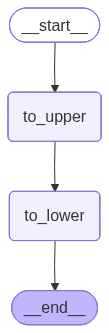

In [ ]:
display(Image(app1.get_graph().draw_mermaid_png()))

### Tu turno
1) Crea un nodo `to_lower` que convierta a minúsculas.  
2) Haz un grafo que primero haga `to_upper` y luego `to_lower` (para ver el flujo).

### Preguntas (¿qué pasa si...?)
- ¿Qué pasa si tu estado no tiene la key que el nodo espera?
- ¿Qué pasa si olvidas conectar un nodo a `END`?

## 2) Aristas condicionales (routing)

### Ejemplo 2: decidir ruta según el input

In [ ]:
from typing import Literal
from pydantic import BaseModel, Field
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnableBranch
from langchain_core.output_parsers import StrOutputParser

from langchain_groq import ChatGroq
classifier_LLM = ChatGroq(model="llama-3.1-8b-instant", temperature=0.2)
print("✅ classifier_LLM listo:", classifier_LLM.model_name)

classifier_prompt = ChatPromptTemplate.from_messages([
    ("system",
     """
     You are a classifier. Your tasks is to classifier the user intention
     choose:
     - 'domainSearch' if the user is asking about Colombian Labor Laws
     - 'summarize' if the user is asking to summarize a document from the Colombian Labor Law domain (e.g.: a law article, a law)
     - 'compare' if the user is asking to compare two or more documents from the Colombian Labor Law domain
     - 'generalSearch' if the user is asking a general question
     Answer only with the JSOM scheme asked.
    """),
    ("user", "question: {question}")
])

class QuestionState(TypedDict):
    question: str

class ClassifyState(TypedDict):
    question: str
    intent: Literal["domainSearch", "summarize", "compare", "generalSearch"] = Field(
        description="User intent."
    )

classifier_chain = classifier_prompt | classifier_LLM.with_structured_output(ClassifyState)

def classify(state: QuestionState):
    question = state["question"]
    classification = classifier_chain.invoke(f"{"question": question}")
    return {
        "question": classification.question
        "intent": classification.intent
        }

def general_search(state: ClassifyState):
    question = state["question"]
    res = classifier_LLM.invoke(f"Answer user question: {question}")
    print("GENERAL SEARCH RESULT:", res)

    return {"response": res.content}

def rag(state: ClassifyState):
    question = state["question"]
    intent = state["intent"]
    print("RAG REQUEST RESULT:", question, intent)
    resp = classifier_LLM.invoke(f"Say which intent is this one: {intent}")

    return {"response": resp.content}


graph = StateGraph(ClassifyState)

graph.add_node("classify", classify)
graph.add_node("general_search", general_search)
graph.add_node("rag", rag)

graph.add_edge(START, "classify")
graph.add_conditional_edges("classify", route)
graph.add_edge("general_search", END)
graph.add_edge("rag", END)

chat = graph.compile()

print(chat.invoke({"question":"¿Qué es LangGraph?"})["out"])
print(chat.invoke({"question":"LangGraph sirve para orquestar flujos con grafos."})["out"])

LangGraph es una herramienta de procesamiento de lenguaje natural (NLP) que permite la creación de gráficas de lenguaje para analizar y visualizar la estructura y relaciones entre las palabras en un texto.
LangGraph es una herramienta que permite orquestar flujos de datos utilizando grafos.


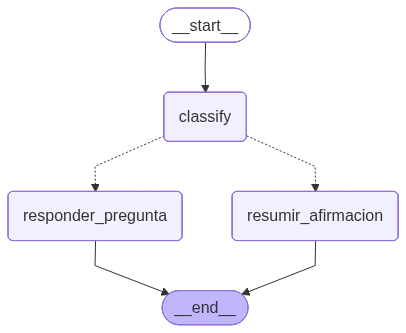

In [ ]:
display(Image(app2.get_graph().draw_mermaid_png()))


### Tu turno
Cambia la regla de routing:
- Si el texto contiene “pasos” → usa un nodo `dar_pasos` (lista 1-3 items).

### Preguntas
- ¿Qué pasa si tu función `route` devuelve un nombre de nodo que no existe?
- ¿Qué pasa si ambos caminos llevan a más nodos y no solo a END?

## 3) Gestión de conversación: historial, truncamiento y resumen

### Ejemplo 3: MessagesState + add_messages

In [ ]:
from langgraph.graph import MessagesState, add_messages
from langchain_core.messages import HumanMessage, AIMessage

# MessagesState ya trae la key "messages" con reducer append-only
def chatbot_node(state: MessagesState):
    resp = llm.invoke(state["messages"])
    return {"messages": [resp]}

g3 = StateGraph(MessagesState)

g3.add_node("chat", chatbot_node)

g3.add_edge(START, "chat")
g3.add_edge("chat", END)

app3 = g3.compile()

state0 = {"messages": [HumanMessage(content="Hola, ¿quién eres?")]}
out = app3.invoke(state0)

out["messages"][-1].content

'Hola. Soy un modelo de inteligencia artificial desarrollado por Meta, diseñado para proporcionar información y responder a preguntas en un rango de temas. Estoy aquí para ayudarte con cualquier cosa que necesites. ¿En qué puedo ayudarte hoy?'

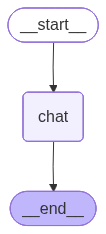

In [ ]:
display(Image(app3.get_graph().draw_mermaid_png()))

### Tu turno
- Haz 2 turnos: agrega el mensaje del usuario y vuelve a invocar.
- Observa cómo crece la lista `messages`.
- Implementa una paso para quitar mensajes
- Implementa una paso para resumir mensajes

### Preguntas
- ¿Por qué guardar todo el historial puede ser costoso?
- ¿Qué ventajas tiene “resumir” vs “borrar” mensajes?